# Compound pipeline

Nebula automatically assemble compoud pipeline by recursively parsing them. , therefore a flat/split pipeline may contain nested pipelines

This notebook shows situations where it is beneficial to break a pipeline into smaller ones and explains the rationale behind this practice.

In [2]:
import sys

from pyspark.sql import functions as F
from pyspark.sql.types import *

import yaml

from nebula.spark_transformers import *
from nebula.base import Transformer
from nebula.pipelines.pipelines import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline
from nebula.storage import nebula_storage as ns

py_version = ".".join(map(str, (sys.version_info[0:2])))
print("python version:", py_version)

python version: 3.7


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 14:07:48 WARN [Thread-3] Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/16 14:07:48 WARN [Thread-3] Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
schema = [
    StructField("c1", FloatType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
]

data = [
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [1.1234, "a", "  b"],
    [2.1234, "  a  ", "  b  "],
    [3.1234, "", ""],
    [4.1234, "   ", "   "],
    [5.1234, None, None],
    [6.1234, " ", None],
    [7.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "   ", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [13.1234, None, "b"],
    [14.1234, None, None],
]

df_input = spark.createDataFrame(data, schema=StructType(schema)).cache()
df_input.show()

NameError: name 'spark' is not defined

### The `TransformerPipeline` object can take as input:
- a transformer
- a list of transformers
- list of lists of transformers
- another pipeline
- list of pipelines

#### The following 3 pipelines are equivalent.

In [4]:
first_stage_pipe = TransformerPipeline([
        EmptyStringToNull(columns=["c2", "c3"]),
        Distinct(),
        CoalescePartitions(num_partitions=5)
    ], 
    name="first-stage"
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "first-stage" (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5


In [5]:
first_stage_pipe = TransformerPipeline([  # list of lists
        [EmptyStringToNull(columns=["c2", "c3"])],
        [Distinct(), CoalescePartitions(num_partitions=5)]
    ], 
    name="first-stage"
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "first-stage" (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5


In [6]:
first_stage_pipe = TransformerPipeline([  # another pipeline and a list of list
        [EmptyStringToNull(columns=["c2", "c3"])],
        TransformerPipeline([Distinct(), CoalescePartitions(num_partitions=5)], name="nested-pipeline")
    ], 
    name="first-stage"
)

first_stage_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "first-stage" (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
*** TransformerPipeline ***: "nested-pipeline" (2 transformers)
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5


### Opting for `list of lists` or `nested pipelines` instead of `flat lists`

Using a list of lists, as opposed to a flat list, provides the flexibility to store and reuse sublists for other pipelines or switch them based on configurations, such as transitioning between different countries or stages like `dev` and `prod`.

The same is true when using another nested pipeline instead of a sublist, with the difference that a nested pipelines has additional properties compared to a simple list. For instance:
- It can be associated with a name that will be displayed in the log.
- If the nested pipeline is a split one, it can be associated with all the properties outlined in notebook `02` such as.
    - `split_apply_before_appending`
    - `split_cast_to_input_schema`
    - `repartition_output_to_original`
    - `coalesce_output_to_original`
- It retains all the attributes relative to the interleaved transformers (see next notebook, `07`)

### Everything covered so far holds true for the split pipelines as well

The splits can be:
- a transformer
- a list of transformers
- list of lists of transformers
- another pipeline
- list of pipelines

In the following example the split `low` is a `list` and the `hi` split is a `TransformerPipeline` object.

In [7]:
def my_split_function(df):
    cond = F.col("c1") < 10
    return {
        "low": df.filter(cond),
        "hi": df.filter(~cond),
    }


low_values = [RoundValues(input_columns="c1"), Cast(cast={ "c1": "float" })]  # This can be a list ...
hi_values = TransformerPipeline(    # ... or another pipeline
    [EmptyStringToNull(columns="c2"), Cast(cast={ "c1": "float" })],
    name="hi-values-sub-pipeline",
)

split_pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,  # provide here you custom split function
)

split_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (4 transformers)
SPLIT <<< hi >>>:
    *** TransformerPipeline ***: "hi-values-sub-pipeline" (2 transformers)
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1"
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


### Assembling them sequentially

In [8]:
final_pipe = TransformerPipeline(
    [
        first_stage_pipe,
        split_pipe,
    ],
    name="main-pipeline",
)

final_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "main-pipeline" (7 transformers)
*** TransformerPipeline ***: "first-stage" (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
*** TransformerPipeline ***: "nested-pipeline" (2 transformers)
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5
*** TransformerPipeline ***: "split-low-hi-values" (4 transformers)
SPLIT <<< hi >>>:
    *** TransformerPipeline ***: "hi-values-sub-pipeline" (2 transformers)
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1"
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


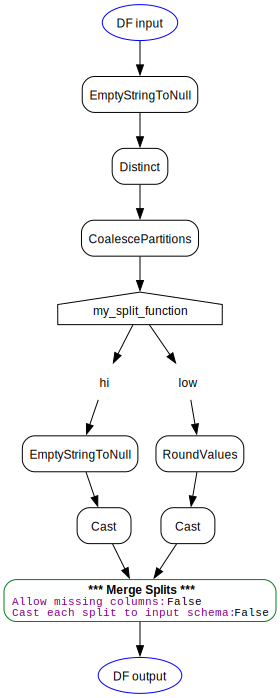

In [9]:
final_pipe.plot_dag()

In [10]:
final_pipe.render_html()

### The same using YAML

In [10]:
yml_data = """
name: "main-pipeline"
pipeline:
 - name: "first-stage"
   pipeline:
     - transformer: EmptyStringToNull
       params:
         columns: ["c2", "c3"]
     - name: "nested-pipeline"
       pipeline:
       - transformer: Distinct
       - transformer: CoalescePartitions
         params:
           num_partitions: 5

 - name: "split-low-hi-values"
   split_function: my_split_function
   pipeline:
     "low":
       - transformer: RoundValues
         params:
           "input_columns": "c1"
           "precision": 1
       - transformer: Cast
         params:
           "cast": { "c1": "float" }

     "hi":
         name: "hi-values-sub-pipeline"
         pipeline:
           - transformer: EmptyStringToNull
             params:
               "columns": "c2"
           - transformer: Cast
             params:
               "cast": { "c1": "float" }
"""

pipe_cfg = yaml.safe_load(yml_data)

final_pipe = load_pipeline(
    pipe_cfg,
    extra_functions={"my_split_function": my_split_function}
)

final_pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "main-pipeline" (7 transformers)
*** TransformerPipeline ***: "first-stage" (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
*** TransformerPipeline ***: "nested-pipeline" (2 transformers)
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5
*** TransformerPipeline ***: "split-low-hi-values" (4 transformers)
SPLIT <<< hi >>>:
    *** TransformerPipeline ***: "hi-values-sub-pipeline" (2 transformers)
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1", precision=1
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


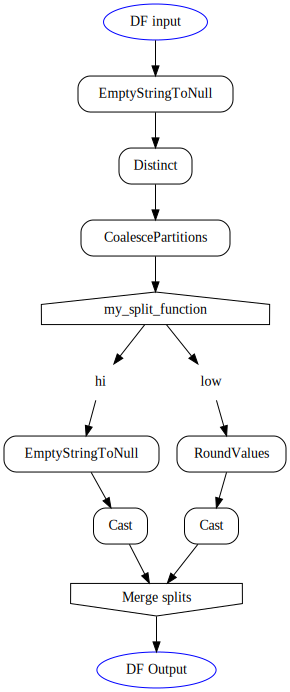

In [11]:
final_pipe.plot_dag()

In [12]:
final_pipe.run(df_input).show()

2024-05-16 14:08:00,912 | pipelines.py:516 [INFO]: Running *** TransformerPipeline ***: "main-pipeline" (7 transformers) 
2024-05-16 14:08:00,913 | pipelines.py:516 [INFO]: Running *** TransformerPipeline ***: "first-stage" (3 transformers) 
2024-05-16 14:08:00,914 | pipelines.py:283 [INFO]: Running EmptyStringToNull -> PARAMS: columns=['c2', 'c3'] ... 
2024-05-16 14:08:01,278 | pipelines.py:297 [INFO]: Execution time for EmptyStringToNull: 0.4s 
2024-05-16 14:08:01,279 | pipelines.py:516 [INFO]: Running *** TransformerPipeline ***: "nested-pipeline" (2 transformers) 
2024-05-16 14:08:01,341 | pipelines.py:283 [INFO]: Running Distinct ... 
2024-05-16 14:08:01,347 | pipelines.py:297 [INFO]: Execution time for Distinct: 0.0s 
2024-05-16 14:08:01,348 | pipelines.py:283 [INFO]: Running CoalescePartitions -> PARAMS: num_partitions=5 ... 
2024-05-16 14:08:01,348 | partitions.py:82 [INFO]: Coalesce to 5 partitions 
2024-05-16 14:08:01,352 | pipelines.py:297 [INFO]: Execution time for Coalesce

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
|12.1234| null|    b|
|10.1234|     |    b|
|13.1234| null|    b|
|14.1234| null| null|
|11.1234|    a| null|
|    4.1|     |     |
|    5.1| null| null|
|    3.1| null| null|
|    8.1|    a| null|
|    7.1| null| null|
|    1.1|    a|    b|
|    9.1|    a| null|
|    6.1|     | null|
|    2.1|  a  |  b  |
|    0.1|    a|    b|
+-------+-----+-----+

